<a href="https://colab.research.google.com/github/tangQAQ/LSTM_training/blob/main/Patten_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed
from google.colab import drive
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import warnings 

warnings.filterwarnings('ignore')

drive.mount('/content/gdrive')
train_data = pd.read_csv("/content/gdrive/MyDrive/GSPC_train.csv", )
train_data = train_data.drop(['Date'], axis= 1)
train_data = train_data.apply(lambda x: pd.to_numeric(x.str.replace(',',''), errors='coerce')).fillna(-1).astype('float32')
train_data.info()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23683 entries, 0 to 23682
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       23683 non-null  float32
 1   High       23683 non-null  float32
 2   Low        23683 non-null  float32
 3   Close      23683 non-null  float32
 4   Adj Close  23683 non-null  float32
 5   Volume     23683 non-null  float32
dtypes: float32(6)
memory usage: 555.2 KB


In [36]:
size = int(len(train_data) * 0.8)
train, val = train_data[:size], train_data[size:]
train.shape, val.shape

((18946, 6), (4737, 6))

In [37]:
def create_sequences(data, sequences):
    X = []
    y = []
    for i in range(sequences, len(data)):
        X.append(data[i-sequences:i, :])
        y.append(data[i, 0])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [38]:
sc = MinMaxScaler(feature_range=(0,1))
sequences = 15

train_data_scaled = sc.fit_transform(train.iloc[:, 4:5])
val_data_scaled = sc.fit_transform(val.iloc[:, 4:5])
X_train, y_train = create_sequences(train_data_scaled, sequences)
X_val, y_val = create_sequences(val_data_scaled, sequences)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((18931, 15, 1), (18931,), (4722, 15, 1), (4722,))

In [39]:
print(X_train[1],y_train[1])

[[0.00874555]
 [0.00863393]
 [0.00870616]
 [0.00860111]
 [0.00851575]
 [0.00850262]
 [0.00858141]
 [0.00865363]
 [0.00846323]
 [0.00846979]
 [0.00844353]
 [0.00852232]
 [0.00858798]
 [0.00869303]
 [0.00873899]] 0.008614238


In [40]:
model = Sequential()
model.add(LSTM(units=30, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))

model.compile(optimizer='Adam', loss='mse')

model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=10, batch_size=32)

Epoch 1/10
592/592 [==============================] - 10s 8ms/step - loss: 6.2089e-04 - val_loss: 3.6513e-04
Epoch 2/10
592/592 [==============================] - 4s 7ms/step - loss: 6.5689e-05 - val_loss: 1.6987e-04
Epoch 3/10
592/592 [==============================] - 5s 8ms/step - loss: 5.5035e-05 - val_loss: 1.2131e-04
Epoch 4/10
592/592 [==============================] - 4s 7ms/step - loss: 4.8499e-05 - val_loss: 1.7521e-04
Epoch 5/10
592/592 [==============================] - 4s 7ms/step - loss: 5.2398e-05 - val_loss: 1.1149e-04
Epoch 6/10
592/592 [==============================] - 4s 7ms/step - loss: 4.3260e-05 - val_loss: 9.3733e-05
Epoch 7/10
592/592 [==============================] - 4s 7ms/step - loss: 3.9978e-05 - val_loss: 1.1187e-04
Epoch 8/10
592/592 [==============================] - 4s 7ms/step - loss: 3.8811e-05 - val_loss: 9.0798e-05
Epoch 9/10
592/592 [==============================] - 4s 7ms/step - loss: 3.6509e-05 - val_loss: 1.1263e-04
Epoch 10/10
592/592 [======

In [41]:
model.evaluate(X_train, y_train, batch_size= 32)

592/592 [==============================] - 2s 3ms/step - loss: 2.9361e-05


2.936095006589312e-05

In [82]:
test_df = pd.read_csv("/content/gdrive/MyDrive/GSPC_test.csv")

test_data = test_df.copy()
test_data = test_data.drop(['Date'], axis= 1)
test_data_clean = test_data.apply(lambda x: pd.to_numeric(x.str.replace(',',''), errors='coerce')).fillna(-1).astype('float32')

preds = list()
days = 15
test_data = test_data_clean.iloc[:days+1, 4:5]

for i in range(1, days+1):
  test_data_scaled = sc.fit_transform(test_data)
  X_test, y_test = create_sequences(test_data_scaled, sequences)
  test_predictions = model.predict(X_test)
  inverse = sc.inverse_transform(test_predictions)
  preds.append(inverse[:, 0])
  test_data.drop(0, inplace=True)
  test_data = test_data.append(pd.Series(inverse[:,0], index=test_data.columns), ignore_index=True)


1/1 [==============================] - 0s 21ms/step


In [70]:
preds

[array([4210.0225], dtype=float32),
 array([4203.6626], dtype=float32),
 array([4202.185], dtype=float32),
 array([4201.887], dtype=float32),
 array([4202.101], dtype=float32),
 array([4201.955], dtype=float32),
 array([4201.782], dtype=float32),
 array([4202.048], dtype=float32),
 array([4202.1987], dtype=float32),
 array([4202.2246], dtype=float32),
 array([4202.267], dtype=float32),
 array([4202.3604], dtype=float32),
 array([4202.369], dtype=float32),
 array([4202.434], dtype=float32),
 array([4202.504], dtype=float32)]

In [66]:
model.evaluate(X_test, y_test, batch_size= 32)

1/1 [==============================] - 0s 44ms/step - loss: 2.1012e-07


2.1012095885453164e-07

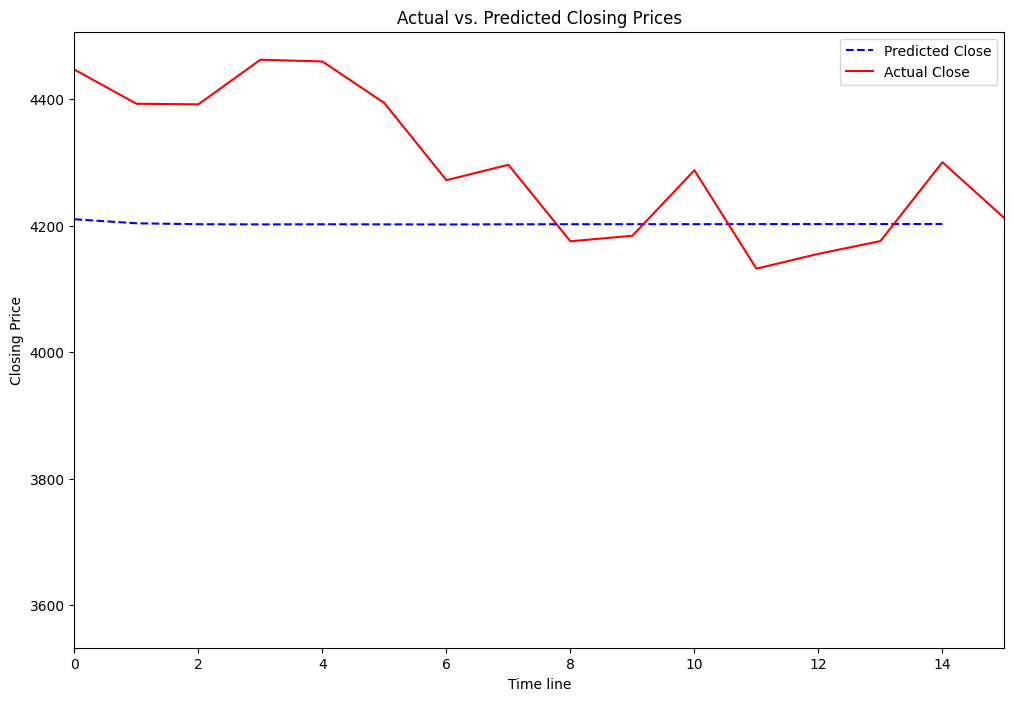

In [85]:
from numpy.ma import left_shift
import matplotlib.ticker as ticker


limit = sequences + days
Actual_Close = test_data_clean['Close'].drop(sequences)

result = preds

plt.figure(figsize=(12, 8))
plt.title('Actual vs. Predicted Closing Prices')
plt.xlabel('Time line')
plt.ylabel('Closing Price')
plt.plot(result, label='Predicted Close', color='b', linestyle='--')
plt.plot(Actual_Close, label='Actual Close', color='r')
plt.xlim([0,days])
#plt.ylim([max(Actual_Close), min(result)])
ax= plt.gca()
#ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.legend()
plt.show()